/Users/cyj/anaconda3/envs/py38/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
100%|██████████| 50000/50000 [36:20<00:00, 22.93it/s]


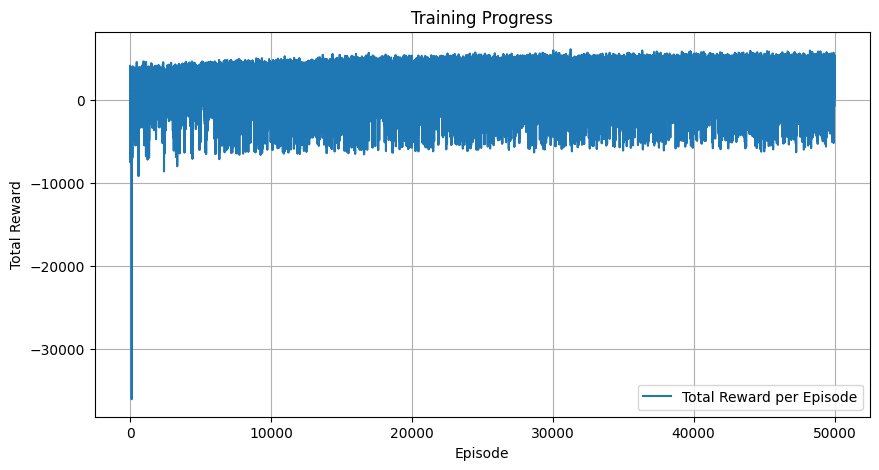

In [10]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt


class PolicyNetwork(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_size=64):
        super(PolicyNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_dim)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        logits = self.fc3(x)
        return logits

# 简单的训练循环
# 使用REINFORCE算法：对每个智能体独立地基于蒙特卡洛方法更新策略。
# 假设各智能体共享经验（集中训练），但决策分散执行——即每个智能体在执行时只访问自己的网络和观测。

def train_multiagent(env, num_episodes=3000, gamma=0.99, lr=0.001):
    # 根据env初始化
    # 重置环境以确定各agent观测空间维度
    obs = env.reset()
    agents = env.agents
    
    # 为每个agent建立独立的策略网络和优化器
    # 不同agent的obs空间大小可能不同
    policies = {}
    optimizers = {}
    for agent in agents:
        obs_dim = env.observation_space(agent).shape[0]
        act_space = env.action_space(agent).n
        policy = PolicyNetwork(obs_dim, act_space)
        policies[agent] = policy
        optimizers[agent] = optim.Adam(policy.parameters(), lr=lr)
    
    # 记录所有回合的总奖励
    total_rewards_history = []
    
    # 开始训练
    for episode in tqdm(range(num_episodes)):
        obs = env.reset()
        done = {agent: False for agent in agents}
        done_flag = False
        
        # 存储本回合数据(各agent分开存)
        # 对每个agent存储obs,act,rew用于回溯计算梯度
        trajectories = {agent: {"obs": [], "actions": [], "rewards": []} for agent in agents}
        
        while not done_flag:
            actions = {}
            for agent in agents:
                obs_tensor = torch.FloatTensor(obs[agent]).unsqueeze(0)
                with torch.no_grad():
                    logits = policies[agent](obs_tensor)
                probs = torch.softmax(logits, dim=-1)
                action = torch.multinomial(probs, 1).item()
                actions[agent] = action
            
            next_obs, rewards, dones, infos = env.step(actions)
            
            # 记录数据
            for agent in agents:
                trajectories[agent]["obs"].append(obs[agent])
                trajectories[agent]["actions"].append(actions[agent])
                trajectories[agent]["rewards"].append(rewards[agent])
            
            obs = next_obs
            done_flag = all(dones.values())
        
        # 回合结束后计算每个agent的回报，并更新策略
        # 使用REINFORCE：G_t = sum_{k=0 to end} gamma^k * r_{t+k+1}
        for agent in agents:
            returns = []
            G = 0
            # 从后向前计算折扣回报
            for r in reversed(trajectories[agent]["rewards"]):
                G = r + gamma * G
                returns.insert(0, G)
            
            # 标准REINFORCE更新
            obs_batch = torch.FloatTensor(trajectories[agent]["obs"])
            action_batch = torch.LongTensor(trajectories[agent]["actions"])
            return_batch = torch.FloatTensor(returns)
            
            # 对策略进行更新
            optimizers[agent].zero_grad()
            logits = policies[agent](obs_batch)
            log_probs = torch.log_softmax(logits, dim=-1)
            chosen_log_probs = log_probs.gather(1, action_batch.unsqueeze(1)).squeeze(1)
            
            # 损失为 -E[G_t * log π(a_t|s_t)]
            loss = -(chosen_log_probs * return_batch).mean()
            loss.backward()
            optimizers[agent].step()
        
        # 记录总奖励
        total_reward_this_episode = sum([sum(trajectories[agent]["rewards"]) for agent in agents])
        total_rewards_history.append(total_reward_this_episode)
    
    return total_rewards_history, policies

from env_new.MAenv_2 import CustomMAEnvironment2
# 创建环境
if __name__ == "__main__":
    # 创建环境
    env = CustomMAEnvironment2(num_agents=5, num_iterations=200, dt=0.1)
    # 开始训练
    rewards_history, policies = train_multiagent(env, num_episodes=100000, gamma=0.99, lr=0.001)
    
    # 绘制总体回报的变化曲线
    plt.figure(figsize=(10,5))
    plt.plot(rewards_history, label="Total Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.title("Training Progress")
    plt.legend()
    plt.grid(True)
    plt.show()

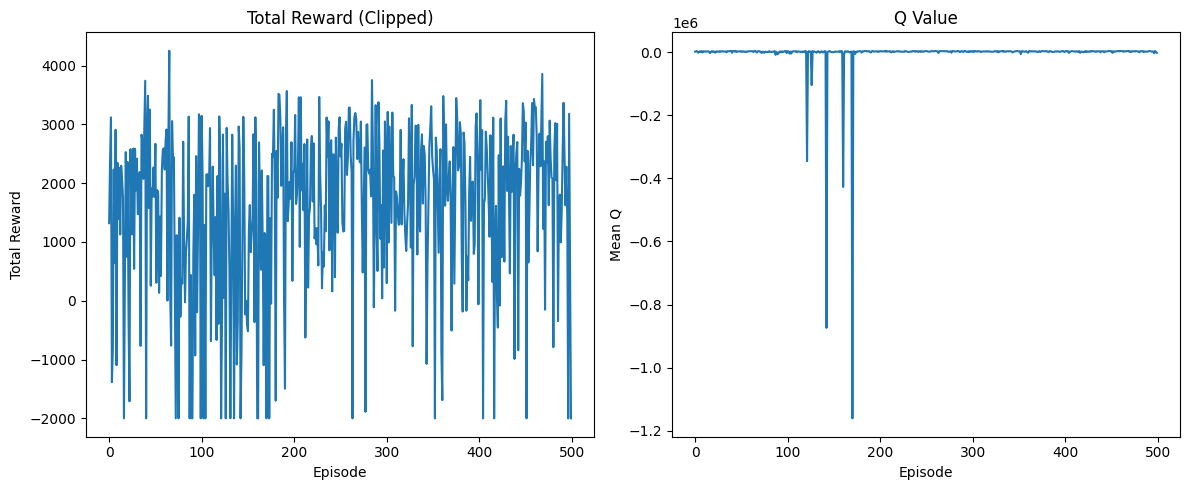

In [2]:
# 对 reward_history 中小于 -1000 的值进行修改，将其设置为 -1000
reward_history_fix = [max(r, -2000) for r in rewards_history]

# 重新绘制曲线，观察修改后的效果
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title("Total Reward (Clipped)")
plt.plot(reward_history_fix)
plt.xlabel("Episode")
plt.ylabel("Total Reward")

plt.subplot(1, 2, 2)
plt.title("Q Value")
plt.plot(rewards_history)
plt.xlabel("Episode")
plt.ylabel("Mean Q")

plt.tight_layout()
plt.show()


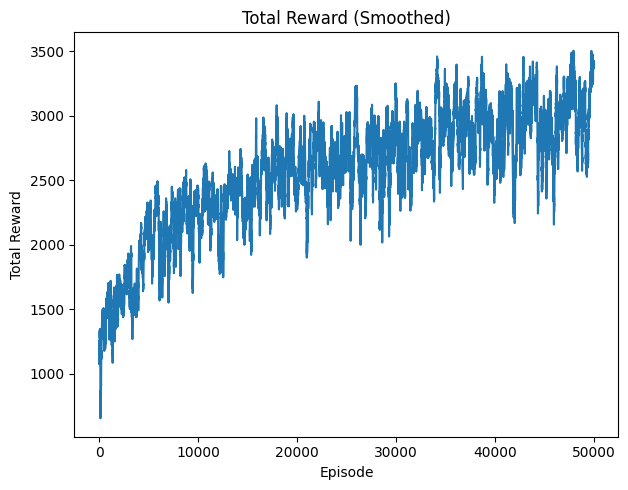

In [11]:
# 使用平滑函数对数据进行平滑处理
def smooth(data, weight=0.99):
    smoothed = []
    last = data[0]
    for point in data:
        smoothed_value = last * weight + (1 - weight) * point
        smoothed.append(smoothed_value)
        last = smoothed_value
    return smoothed

# 对奖励历史和Q值历史进行平滑
smoothed_reward_history = smooth(rewards_history)
#smoothed_q_value_history = smooth(q_value_history)

# 绘制平滑后的曲线
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.title("Total Reward (Smoothed)")
plt.plot(smoothed_reward_history)
plt.xlabel("Episode")
plt.ylabel("Total Reward")


plt.tight_layout()
plt.show()
